                Ålesund  Kristiansand    Drammen       Oslo  Kristiansund     Bergen  Stavanger       Bodø     Tromsø   Kirkenes
Ålesund        0.000000      4.699014   4.842845   5.259821      1.722902   2.245541   3.524308   9.547133  14.674660  24.971927
Kristiansand   4.699014      0.000000   2.683645   3.272372      4.967970   3.487256   2.408069  11.153235  15.888877  24.904230
Drammen        4.842845      2.683645   0.000000   0.620236      4.136085   4.876263   4.488215   8.650204  13.254091  22.255806
Oslo           5.259821      3.272372   0.620236   0.000000      4.380977   5.449884   5.105223   8.219051  12.734284  21.646225
Kristiansund   1.722902      4.967970   4.136085   4.380977      0.000000   3.652588   4.605253   7.847034  12.968717  23.255853
Bergen         2.245541      3.487256   4.876263   5.449884      3.652588   0.000000   1.472507  11.400703  16.482755  26.431781
Stavanger      3.524308      2.408069   4.488215   5.105223      4.605253   1.472507   0.000000  

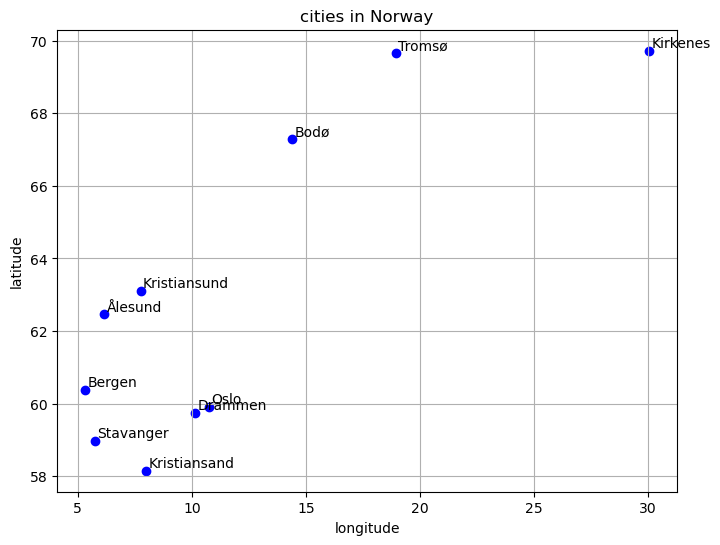

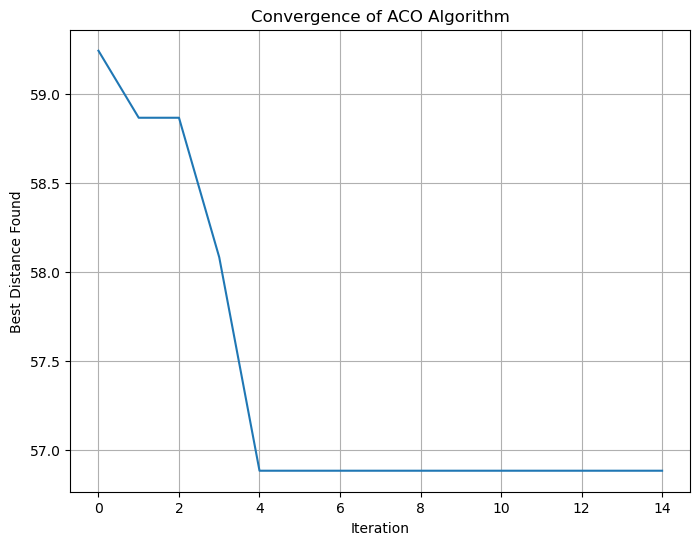

In [62]:
import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import random 

#List of the 10 different cities in norway with the coordinates to spread them out so it won't make a circular path
cities = {
    "Ålesund": (62.47170452288225, 6.153556931462541),
    "Kristiansand": (58.14989118697506, 7.998186353271645),
    "Drammen": (59.745347438290814, 10.156071370061078),
    "Oslo": (59.917930178088056, 10.751812714908365),
    "Kristiansund": (63.11181408891499, 7.753135154616366),
    "Bergen": (60.3857881925893, 5.322048168559406),
    "Stavanger": (58.97234881125637, 5.7349235952920425),
    "Bodø": (67.28312609437272, 14.399645108555967),
    "Tromsø": (69.66892721724163, 18.94205347444131),
    "Kirkenes": (69.7254170154431, 30.048761679946026),
}


cityNames = list(cities.keys()) #extracts the city names into a new list
coordinates = np.array(list(cities.values())) #extracts the coordinates

xCoords, yCoords = zip(*coordinates) # will save the coordinates as a tuple, x for latitude and y for longitude

# scatters the coordinates of the cities and mark the position with a blue circle
plt.figure(figsize=(8,6))
plt.scatter(yCoords, xCoords, color = 'blue', marker = 'o', label = 'cities')

# iterates through the cities to label the positions with the city name a little bit next to the marker
for i, city in enumerate(cityNames):
    plt.text(yCoords[i] + 0.1, xCoords[i], city, fontsize = 10, verticalalignment = 'bottom')

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("cities in Norway")
plt.grid(True)

#makes a matrix of distances between all pairs of cities using the coordinates
distanceMatrix = cdist(coordinates, coordinates)
distance_df = pd.DataFrame(distanceMatrix, index=cityNames, columns=cityNames) #converts the distance martix into a pandas Dataframe 
pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.width', 1000) 

print(distance_df) #prints the complete distance matrix showing all the possible distances between the pairs

#parameters for the algorithm
numAnts = 10
iterations = 15
alpha = 1
beta = 2
evaporation = 0.5
pheromoneAdded = 10
pheromone = np.ones((10,10)) #initial pheromone matrix

#calculates the probabilities for an ant to choose each unvisited city based on the pheromones and distance
def calculateProbabilities(currentCity, unvisited, pheromone, distanceMatrix, alpha, beta):
    probabilities = []
    for nextCity in unvisited: #calculates how attractive the city is using the pheromone (tau) and distance as eta
        tau = pheromone[currentCity, nextCity]**alpha
        eta = (1/distanceMatrix[currentCity, nextCity])**beta
        probabilities.append(tau*eta)

    probabilities = np.array(probabilities)
        
    if sum(probabilities) == 0:
        #gives all options equal probability if the probabilites are zero
        probabilities = np.ones(len(probabilities))/len(probabilities)
    else:
        #here I divide each value by the total so they sum to 1
        probabilities /= probabilities.sum()
    return probabilities

#calculates the total distance of a route by using the distance matrix to find the distance for the routes used to make the full route
def calculateCostDistance(route, distanceMatrix):
    totalDistance = sum(distanceMatrix[route[i], route[i+1]] for i in range(len(route)-1))
    totalDistance += distanceMatrix[route[-1], route[0]]
    return totalDistance

#constructs a route for an ant using selection based on probability
def constructRoute(pheromone, distanceMatrix, alpha, beta):
    currentCity = random.randint(0,9) #starts at a random city
    unvisited = set(range(10)) - {currentCity}
    route = [currentCity]

    #this will make the ant visit the rest of the unvisited cities
    while unvisited:
        #calculates the probability for the next city based on pheromones and distance 
        probabilities = calculateProbabilities(currentCity, unvisited, pheromone, distanceMatrix, alpha, beta)
        nextCity = np.random.choice(list(unvisited), p = probabilities) #selecting the next city based on the probabilies
        route.append(nextCity)
        unvisited.remove(nextCity)
        currentCity = nextCity

    return route


bestRoute = None
bestDistance = float('inf') #starting with infinity makes it so any route with a real distance will be better
bestDistances = [] #tracking the best distnace per iteration for the plotting

#runs the algorithm as long as iterations-variable specifies
for iteration in range(iterations):
    allRoutes = []
    allDistances = [] #stores the distnaces of all routes in this iteration

    #each ant constructs a route 
    for ant in range(numAnts):
        route = constructRoute(pheromone, distanceMatrix, alpha, beta) #the ants uses pheromones and distnaces to build their route
        totalDistance = calculateCostDistance(route, distanceMatrix) #calculates the total distnace of the their route

        #stores teh ant's route information
        allRoutes.append(route)
        allDistances.append(totalDistance)

        #updates the bestRoute (solution) if it finds a one with lower distnace 
        if totalDistance < bestDistance:
            bestDistance = totalDistance
            bestRoute = route 

    bestDistances.append(bestDistance) #stores it for plotting
    
    pheromone *= (1-evaporation) #evaporates pheromones on all paths

    #Based on the quality of the route this will add pheromones
    for i in range(numAnts):
        for j in range(9):
            pheromone[allRoutes[i][j], allRoutes[i][j+1]] += pheromoneAdded/allDistances[i]
        pheromone[allRoutes[i][-1], allRoutes[i][0]] += pheromoneAdded/allDistances[i]

    #prints the progress update    
    print(f"iteration {iteration + 1}: Best distance = {bestDistance}")
    
#prints the final best route and the distnace it has
print("best route: ", [cityNames[i] for i in bestRoute], "best distance: ", bestDistance)

#convergence plotting for visual representation of the algorithms solutions
plt.figure(figsize=(8, 6))  
plt.plot(range(iterations), bestDistances)
plt.xlabel("Iteration")
plt.ylabel("Best Distance Found")
plt.title("Convergence of ACO Algorithm")
plt.grid(True)
plt.show()